In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [2]:
basePath = '/content/drive/MyDrive/AIML/univariate_timeseries_LSTM'

In [3]:
airPassenger = os.path.join(basePath,'AirPassengers.csv')

In [4]:
airPassenger_data = pd.read_csv(airPassenger)
airPassenger_data.rename(columns={'#Passengers':'Passengers'},inplace=True)
print(airPassenger_data.shape)
airPassenger_data.head()

(144, 2)


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
year_start = [airPassenger_data.Month.values[idx] for idx in range(0,airPassenger_data.shape[0],12)]
year_start.append(airPassenger_data.Month.values[airPassenger_data.shape[0]-1])

Text(0, 0.5, 'Number of passengers')

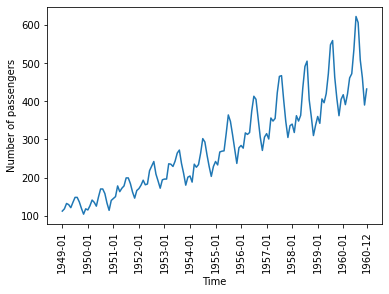

In [6]:
sns.lineplot(data=airPassenger_data,x='Month',y='Passengers')
plt.xticks(year_start, rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Number of passengers')

In [7]:
passenger_data = airPassenger_data['Passengers'].values.reshape(len(airPassenger_data),1)
passenger_data.shape

(144, 1)

In [48]:
# Split data into 70:30
train_split = 0.7
train_size = int(train_split * len(passenger_data))
trainData = passenger_data[:train_size]
valData = passenger_data[train_size:]
print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (100, 1)
Val data size:  (44, 1)


In [49]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(trainData)
sclaed_data_train = scaler.transform(trainData)
sclaed_data_test = scaler.transform(valData)

In [51]:
# looking at every last 5months data as input and adding 6th month data as output

time_span = 6
def prepareData(data,span):
    x = []
    y = []
    for idx in range(0,len(data)-span):
        x.append(data[idx: idx+span])
        y.append(data[idx+span])
    return np.array(x),np.array(y)

In [52]:
train_x,train_y = prepareData(sclaed_data_train,time_span)
test_x,test_y = prepareData(sclaed_data_test,time_span)

In [53]:
train_x.shape,train_y.shape

((94, 6, 1), (94, 1))

In [54]:
from tensorflow import keras

In [55]:

def createModel(in_shape=(6,1)):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=64,return_sequences=True,input_shape=in_shape))
    model.add(keras.layers.LSTM(units=64,return_sequences=False))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model


In [56]:
model = createModel()
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=50,batch_size=1,verbose=1,callbacks=[callback])

Epoch 1/50
94/94 [==============================] - 3s 11ms/step - loss: 0.0281 - val_loss: 0.1385
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0190 - val_loss: 0.0825
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0182 - val_loss: 0.0848
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0178 - val_loss: 0.0724
Epoch 5/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0178 - val_loss: 0.0687
Epoch 6/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0164 - val_loss: 0.0621
Epoch 7/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0607
Epoch 8/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0722
Epoch 9/50
94/94 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0475
Epoch 10/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0131 - val_loss: 0.0786
Epoch 11/50
94/94 

In [57]:
y_train_hat = scaler.inverse_transform(model.predict(train_x))
y_val_hat = scaler.inverse_transform(model.predict(test_x))

Text(0, 0.5, 'Number of passengers')

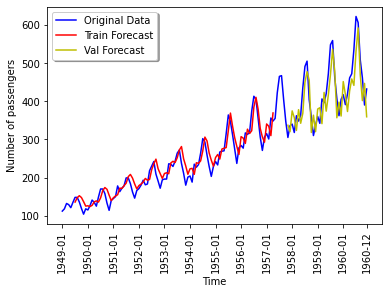

In [58]:
train_shift = time_span
test_shift = train_shift + len(y_train_hat) + time_span

plt.plot(airPassenger_data['Month'], airPassenger_data['Passengers'], color='b', label="Original Data")
plt.plot(airPassenger_data['Month'][train_shift: test_shift-time_span], y_train_hat, color='r', label="Train Forecast")
plt.plot(airPassenger_data['Month'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(year_start, rotation='vertical')
plt.xlabel('Time')
plt.ylabel('Number of passengers')